# Plot profile likelihoods and posteriors for $\Lambda$CDM, $\Lambda$CDM+$M_\nu$, $w_0$CDM

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.interpolate import interp1d
from getdist import loadMCSamples
from getdist import plots

## Data from minimizations

### $\Lambda$CDM

In [2]:
# Planck
hs_Planck     =  np.array([ 0.66  ,  0.6625,  0.665 ,  0.6675,  0.67  ,  0.6725,  0.675 ,  0.6775,   0.68  ,  0.6825,  0.685 ])
chi2_h_Planck =  np.array([2781.12, 2778.84, 2777.02, 2775.62, 2774.66, 2774.16, 2774.14,  2774.5 , 2775.3 , 2776.48, 2778.1 ])
# Planck+BAO
hs_BAO        =  np.array([  0.655 ,  0.66  ,  0.665 ,  0.6675,  0.67  ,  0.6725,  0.675 ,  0.6775,  0.68  ,  0.685 ,  0.69  ,  0.695 ])
chi2_h_BAO    =  np.array([ 2807.  , 2795.78, 2787.6 , 2784.6 , 2782.34, 2780.82, 2780.  , 2779.9 , 2780.44, 2783.62, 2789.4 , 2797.82])
# Planck-lite
hs_lite       =  np.array([0.645 , 0.65  , 0.655 , 0.66  , 0.665 , 0.6675, 0.67  , 0.6725, 0.675 , 0.6775, 0.68  , 0.685 , 0.69  , 0.695 , 0.7   ])
chi2_h_lite   =  np.array([600.84, 594.24, 589.16, 585.58, 583.44, 582.92, 582.76, 582.96, 583.48, 584.34, 585.54, 588.98, 593.74, 599.8 , 607.12])

### $\Lambda$CDM+$M_\nu$

In [3]:
# Planck
Mnus_Planck     =  np.array([   0.  ,    0.03,    0.06,    0.09,    0.12,    0.15,    0.18,    0.21,    0.24,    0.27,    0.3 ])
chi2_Mnu_Planck =  np.array([2772.88, 2773.18, 2773.64, 2774.2 , 2774.84, 2775.52, 2776.28, 2777.02, 2777.8 , 2778.6 , 2779.42])
# Planck+BAO
Mnus_BAO        =  np.array([   0.  ,    0.03,    0.06,    0.09,    0.12,    0.15,    0.18,    0.21,    0.24,    0.27,    0.3 ])
chi2_Mnu_BAO    =  np.array([2778.14, 2778.6 , 2779.56, 2780.86, 2782.54, 2784.54, 2786.92, 2789.64, 2792.64, 2795.9 , 2799.46])
# Planck-lite
Mnus_lite       =  np.array([   0.  ,    0.03,    0.06,    0.09,    0.12,    0.15,    0.18,    0.21,    0.24,    0.27,    0.3 ])
chi2_Mnu_lite   =  np.array([581.7 , 581.96, 582.48, 583.04, 583.66, 584.32, 585.  , 585.7 , 586.36, 587.  , 587.66])

### $w_0$CDM

In [4]:
# Planck
w0s_Planck     =  np.array([  -0.85,   -0.9 ,   -0.95,   -1.  ,   -1.05,   -1.1 ,   -1.15,   -1.2 ,   -1.25,   -2.  ,   -1.9 ,   -1.8 ,   -1.7 ,   -1.6 ,   -1.5 ,   -1.4 ,   -1.3 ,   -1.2 ,   -2.4 ,   -2.2 ,   -2.  ,   -1.8 ,   -1.6 ,   -1.4 ,   -1.2 ,   -1.  ,   -0.8 ])
chi2_w0_Planck =  np.array([2776.78, 2775.72, 2774.84, 2774.06, 2773.44, 2772.94, 2772.5 , 2772.12, 2771.78, 2769.8 , 2769.9 , 2770.04, 2770.2 , 2770.42, 2770.66, 2771.  , 2771.48, 2772.12, 2769.6 , 2769.66, 2769.82, 2770.04, 2770.42, 2771.  , 2772.12, 2774.06, 2778.1 ])
# Planck+BAO
w0s_BAO        =  np.array([  -0.9 ,   -0.95,   -1.  ,   -1.05,   -1.1 ,   -1.15,   -1.2 ])
chi2_w0_BAO    =  np.array([2787.58, 2782.54, 2780.08, 2779.66, 2781.12, 2784.06, 2788.3 ])
# Planck-lite
w0s_lite       =  np.array([  -0.4,   -0.6,   -0.8,   -1. ,   -1.2,   -1.4,   -1.6,   -1.8,   -2. ,   -2.2,   -2.4])
chi2_w0_lite   =  np.array([600.74, 589.56, 585.  , 582.76, 581.5 , 580.76, 580.26, 579.94, 579.7 , 579.54, 579.4 ])

## Preliminaries for graphical construction of confidence intervals
Define parabola for simple graphical construction

In [5]:
def parab(x, a,b,c):
    return a + b * (x-c)**2.

Neyman construction for a Gaussian with boundary at 0 (Feldman-Cousins constr.), see `Neyman_construction.ipynb`

In [6]:
# Neyman construction in terms of LR test statistic in units of sigma (i.e. sigma=1)
mu_FC = np.array([    0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000, 0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000, 0.9500, 1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000, 1.3500, 1.4000, 1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500, 1.8000, 1.8500, 1.9000, 1.9500, 2.0000, 2.0500, 2.1000, 2.1500, 2.2000, 2.2500, 2.3000, 2.3500, 2.4000, 2.4500, 2.5000, 2.5500, 2.6000, 2.6500, 2.7000, 2.7500, 2.8000, 2.8500, 2.9000, 2.9500, 3.0000, 3.0500, 3.1000, 3.1500, 3.2000, 3.2500, 3.3000, 3.3500, 3.4000, 3.4500, 3.5000, 3.5500, 3.6000, 3.6500, 3.7000, 3.7500, 3.8000, 3.8500, 3.9000, 10.000])
tLR_68_FC = np.array([0.2444, 0.2444, 0.3438, 0.4367, 0.5181, 0.5897, 0.6530, 0.7091, 0.7586, 0.8023, 0.8407, 0.8741, 0.9029, 0.9274, 0.9480, 0.9647, 0.9780, 0.9879, 0.9948, 0.9988, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tLR_95_FC = np.array([2.8566, 2.8566, 2.8566, 2.8566, 2.8566, 2.8566, 2.8566, 2.8570, 2.8594, 2.8680, 2.8871, 2.9182, 2.9602, 3.0105, 3.0664, 3.1258, 3.1868, 3.2483, 3.3093, 3.3690, 3.4270, 3.4829, 3.5365, 3.5874, 3.6356, 3.6809, 3.7233, 3.7626, 3.7988, 3.8320, 3.8621, 3.8891, 3.9131, 3.9340, 3.9520, 3.9670, 3.9791, 3.9884, 3.9949, 3.9987, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000])

# Interpolate
tLR_95_mu = interpolate.make_interp_spline(mu_FC, tLR_95_FC)
tLR_68_mu = interpolate.make_interp_spline(mu_FC, tLR_68_FC)

# Neyman construction in terms of the parameter
x0s = np.array([      -3.00000000, -2.9000000, -2.8000000, -2.7000000, -2.6000000, -2.5000000, -2.4000000, -2.3000000, -2.2000000, -2.1000000, -2.0000000, -1.9000000, -1.8000000, -1.7000000, -1.6000000, -1.5000000, -1.4000000, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,       -2.00000000e-01, -1.00000000e-01,  2.66453526e-15,  1.00000000e-01,        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,        1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,        1.80000000e+00,  1.90000000e+00,  2.00000000e+00,  2.10000000e+00,        2.20000000e+00,  2.30000000e+00,  2.40000000e+00,  2.50000000e+00,        2.60000000e+00,  2.70000000e+00,  2.80000000e+00,  2.90000000e+00,        3.00000000e+00])
CL95_upper = np.array([0.44480255, 0.45865505, 0.47346399, 0.48936427, 0.50651173, 0.52508606, 0.5452902 , 0.56733527, 0.59147626, 0.61798482, 0.64715761, 0.67928624, 0.71467396, 0.7535998 , 0.79631322, 0.84302084, 0.89387108, 0.94894641, 1.00826074, 1.07176277, 1.13934387, 1.21084903, 1.28609211, 1.36487003, 1.44697621, 1.53221235, 1.62039817, 1.71137824, 1.80502732, 1.90125384, 2.00000244, 2.10000244, 2.20000244, 2.30000244, 2.40000244, 2.50000244, 2.60000244, 2.70000244, 2.80000244, 2.90000244, 3.00000244, 3.10000244, 3.20000244, 3.30000244, 3.40000244, 3.50000244, 3.60000244, 3.70000244, 3.80000244, 3.90000244, 4.00000244, 4.10000244, 4.20000244, 4.30000244, 4.40000244, 4.50000244, 4.60000244, 4.70000244, 4.80000244, 4.90000244, 5.00000244])

# Interpolate
f_upper95 = interp1d(x0s, CL95_upper, kind='cubic')

In [7]:
# Make the plots beautiful
color_Planck = 'tab:red'
color_BAO    = 'teal'
color_lite   = 'navy'
plt.rc('font',**{'family':'Helvetica','size':12})
plt.rc('text', usetex=True)
font = {'family':'Helvetica',
        'color' : 'black',
        'size'  :  12}

## Compute confidence intervals and plot profiles

### $\Lambda$CDM
For $h$ within the $\Lambda$CDM model, we use the simple graphical construction.

Planck-lite
h =  0.6702931397713424  \pm  0.005995530550154504
----------------
Full Planck
2774.0857042100406 34756.17613730425 0.6741980631469326
h =  0.6741980631469326  \pm  0.005363941007130002
----------------
Full Planck + BAO
h =  0.676849574837731  \pm  0.004197733230133671


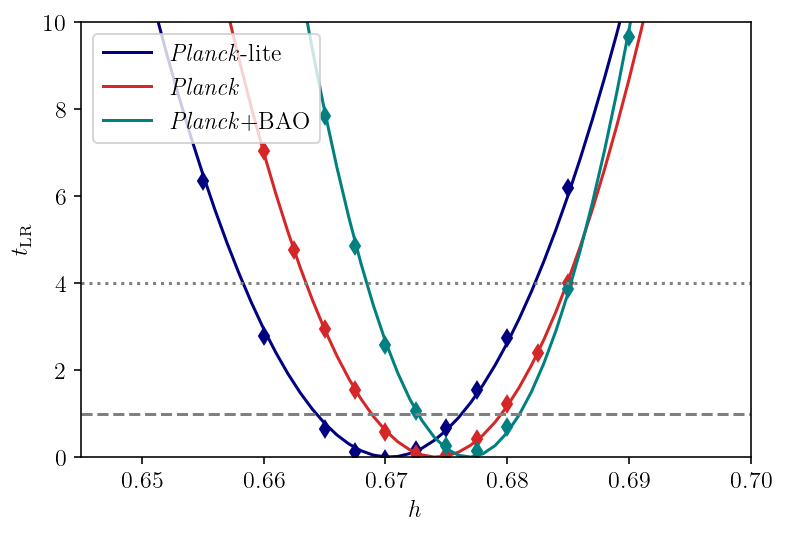

In [8]:
########### Plik_lite
print("Planck-lite")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, hs_lite, chi2_h_lite, p0=[291, 14529, 0.66], maxfev=100000)
fit_x = np.arange(0.6,0.75,0.001)
fit_y = b * (fit_x-c)**2.
parabola_min = a

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
zeros = fsolve(parabola, x0=[0.6, 0.7])
sigma = (zeros[1]-zeros[0])/2.
print("h = ", c, " \pm ", sigma)
print("----------------")

# Plot
plt.plot(hs_lite, chi2_h_lite-parabola_min, marker="d", ls="", color=color_lite )
label=r"\textit{Planck}-lite"#, $h= %(centr).3f \pm %(err).3f \,\mathrm{km/s/Mpc}$"%{"centr":c, "err":sigma}
plt.plot(fit_x, fit_y, color=color_lite , ls='-', label=label)

########### Planck
print("Full Planck")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, hs_Planck, chi2_h_Planck, p0=[291, 14529, 0.66], maxfev=100000)
fit_x = np.arange(0.6,0.75,0.001)
fit_y = b * (fit_x-c)**2.
parabola_min = a
print(a, b, c)

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
zeros = fsolve(parabola, x0=[0.6, 0.7])
sigma = (zeros[1]-zeros[0])/2.
print("h = ", c, " \pm ", sigma)
print("----------------")


# Plot
plt.plot(hs_Planck, chi2_h_Planck-parabola_min, marker="d", ls="", color=color_Planck )
label=r"\textit{Planck}" #", $h= %(centr).3f \pm %(err).3f \,\mathrm{km/s/Mpc}$"%{"centr":c, "err":sigma}
plt.plot(fit_x, fit_y, color=color_Planck , ls='-', label=label)


########### Planck+BAO
print("Full Planck + BAO")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, hs_BAO[:-1], chi2_h_BAO[:-1], p0=[291, 14529, 0.66], maxfev=100000)
fit_x = np.arange(0.6,0.75,0.001)
fit_y = b * (fit_x-c)**2.
parabola_min = a

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
zeros = fsolve(parabola, x0=[0.6, 0.7])
sigma = (zeros[1]-zeros[0])/2.
print("h = ", c, " \pm ", sigma)

# Plot
plt.plot(hs_BAO, chi2_h_BAO-parabola_min, marker="d", ls="", color=color_BAO )
label=r"\textit{Planck}+BAO"#, $h= %(centr).3f \pm %(err).3f \,\mathrm{km/s/Mpc}$"%{"centr":c, "err":sigma}
plt.plot(fit_x, fit_y, color=color_BAO, ls='-', label=label)

########### Make plot
plt.xlabel(r"$h$", fontdict=font)
plt.ylabel(r"$t_\mathrm{LR}$", fontdict=font)
plt.ylim(0, 10)
plt.xlim(0.645, 0.7)
plt.axhline(1., color='grey', ls='--')
plt.axhline(4., color='grey', ls=':')
plt.legend(loc="upper left")
plt.savefig("PL_h.pdf", format="PDF")

### $\Lambda$CDM+$M_\nu$
Here, we will use the Neyman construction for a Gaussian at a physical boundary at 0 (Feldman-Cousins construction).

Planck-lite
577.2711464475689 15.203369614100213 -0.5302718226684519
MLE:  -0.5302718226684519
1 sigma:  0.25646616211744544
x0:  -2.067609302881916
chi2 577.2711464475689
Mnu <  0.16083718114962675  (at 95.45 C.L.)
----------------
Planck
MLE:  -0.2592245346900475
minimum of parabola:  -0.2592245346900475
1 sigma:  0.19112305369959728
x0:  -1.3563226919631084
chi2 2770.9308771181054
Mnu <  0.17533716836352836  (at 95.45 C.L.)
----------------
Planck+BAO
MLE:  -0.04087595307666731
minimum of parabola:  -0.04087595307666731
1 sigma:  0.07291077855094913
x0:  -0.5606297709206838
chi2 2777.7079340035407
Mnu <  0.10792039598428546  (at 95.45 C.L.)
----------------


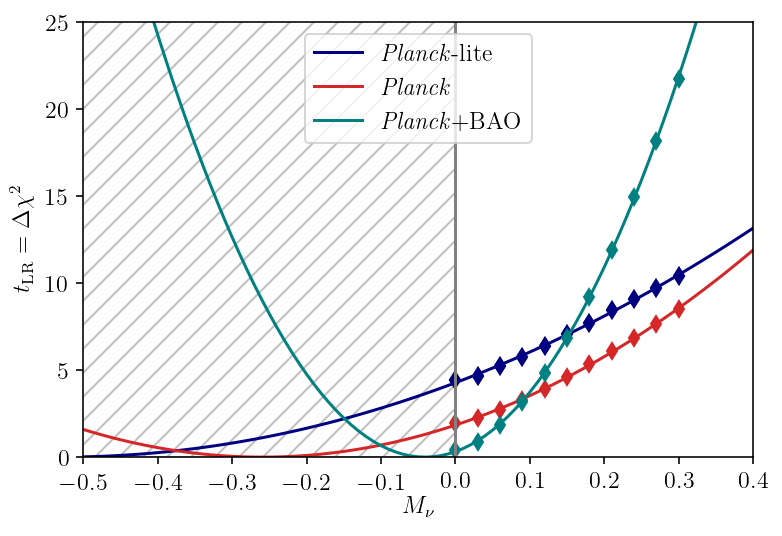

In [9]:
########### Plik_lite
print("Planck-lite")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, Mnus_lite[:], chi2_Mnu_lite[:], p0=[1388., 53., -0.13], maxfev=100000)
fit_x = np.arange(-100,100.,0.01)
fit_y = b * (fit_x-c)**2.
print(a,b,c)
parabola_min = a

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
print("MLE: ", c)
zeros = fsolve(parabola, x0=[-100, 1.])
sigma = (zeros[1]-zeros[0])/2.
print("1 sigma: ", sigma)
x0 = c/sigma
print("x0: ", x0)
print("chi2", a)

# Compute intervals
print("Mnu < ", sigma*f_upper95(x0), " (at 95.45 C.L.)")
print("----------------")

# Plot
plt.plot(Mnus_lite, chi2_Mnu_lite-parabola_min, marker="d", ls="", color=color_lite , fillstyle='none')
plt.plot(Mnus_lite[:], chi2_Mnu_lite[:]-parabola_min, marker="d", ls="", color=color_lite )
label=r"\textit{Planck}-lite"
plt.plot(fit_x, fit_y, color=color_lite, ls='-', label=label)

########### Planck
print("Planck")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, Mnus_Planck, chi2_Mnu_Planck, p0=[1388., 53., -0.13], maxfev=100000)
fit_x = np.arange(-200,1.,0.01)
fit_y = b * (fit_x-c)**2.
parabola_min = a
print("MLE: ", c)

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
print("minimum of parabola: ", c)
zeros = fsolve(parabola, x0=[-200, 1.])
sigma = (zeros[1]-zeros[0])/2.
print("1 sigma: ", sigma)
x0 = c/sigma
print("x0: ", x0)
print("chi2", a)

# Compute intervals
print("Mnu < ", sigma*f_upper95(x0), " (at 95.45 C.L.)")
print("----------------")

# Plot
plt.plot(Mnus_Planck, chi2_Mnu_Planck-parabola_min, marker="d", ls="", color=color_Planck)
label=r"\textit{Planck}"
plt.plot(fit_x, fit_y, color=color_Planck, ls='-', label=label)


########### Planck+BAO
print("Planck+BAO")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, Mnus_BAO, chi2_Mnu_BAO, p0=[2770, 22., -1.3], maxfev=20000)
fit_x = np.arange(-5.,1,0.01)
fit_y = b * (fit_x-c)**2.
parabola_min = a
print("MLE: ", c)

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
print("minimum of parabola: ", c)
zeros = fsolve(parabola, x0=[-1.,1.])
sigma = (zeros[1]-zeros[0])/2.
print("1 sigma: ", sigma)
x0 = c/sigma
print("x0: ", x0)
print("chi2", a)

# Compute intervals
print("Mnu < ", sigma*f_upper95(x0), " (at 95.45 C.L.)")
print("----------------")

# Plot
plt.plot(Mnus_BAO, chi2_Mnu_BAO-parabola_min, marker="d", ls="", color=color_BAO)
label=r"\textit{Planck}+BAO"
plt.plot(fit_x, fit_y, color=color_BAO, ls='-', label=label)

########### Make plot
plt.xlabel(r"$M_\nu$", fontdict=font)
plt.ylabel(r"$t_\mathrm{LR} = \Delta\chi^2$", fontdict=font)
plt.ylim(0, 25)
plt.xlim(-0.5, 0.4)
plt.axvline(0, color='grey', ls='-')
plt.legend()
plt.fill_between(x=[-1.,0], y1=[0], y2=[45], facecolor="white", hatch="//", edgecolor="grey", alpha=0.5)
plt.savefig("PL_Mnu_extrap.pdf", format="PDF")

Planck-lite
577.2711367457403 15.203349244657874 -0.5302727559260448
MLE:  -0.5302727559260448
1 sigma:  0.2564663340348701
x0:  -2.067611555807348
chi2 577.2711367457403
Mnu <  0.16083954619745144  (at 95.45 C.L.)
----------------
Planck
minimum of parabola:  -0.2592245346900475
1 sigma:  0.19112305369959728
x0:  -1.3563226919631084
chi2 2770.9308771181054
Mnu <  0.17533879193158497  (at 95.45 C.L.)
----------------
Planck+BAO
minimum of parabola:  -0.04087595307666731
1 sigma:  0.07291077855094913
x0:  -0.5606297709206838
chi2 2777.7079340035407
Mnu <  0.10791992059907927  (at 95.45 C.L.)
----------------


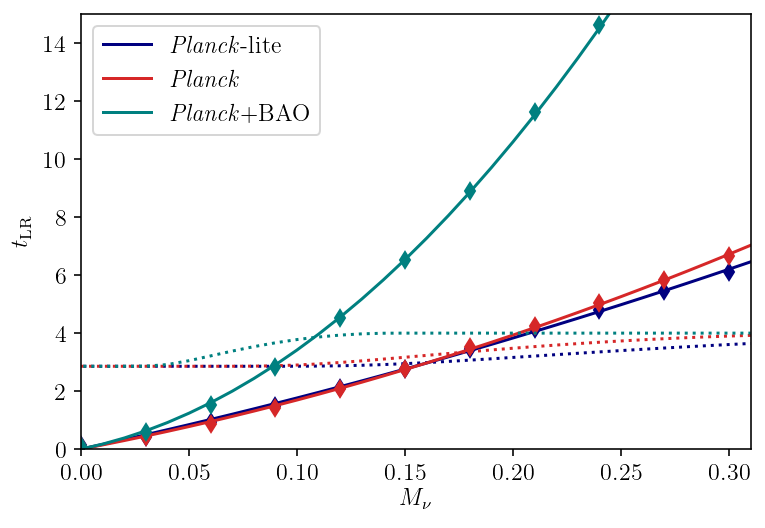

In [10]:
########### Plik_lite
print("Planck-lite")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, Mnus_lite[:], chi2_Mnu_lite[:], p0=[1388., 53., -0.13], bounds=([0, 0, -10000], 10000),  maxfev=1000000)
fit_x = np.arange(-100,50.,0.01)
fit_y = a+ b * (fit_x-c)**2.
print(a,b,c)
ordinate = a + b*c**2

# Find intersection of parabola with \Delta\chi^2 = 1 to obtain estimate of 1sigma
def parabola(x):
    return b * (x-c)**2.  -1
print("MLE: ", c)
zeros = fsolve(parabola, x0=[-100, 10.])
sigma = (zeros[1]-zeros[0])/2.
print("1 sigma: ", sigma)
x0 = c/sigma
print("x0: ", x0)
print("chi2", a)

# Compute Neyman belt in LR-space
def intersection(x):
    return a+b * (x-c)**2. -ordinate- tLR_95_mu(x/sigma)
intersec = fsolve(intersection, x0=[0, 100])[0]
print("Mnu < ", intersec, " (at 95.45 C.L.)")
print("----------------")

# Plot
label=r"\textit{Planck}-lite"
plt.plot(Mnus_lite[:], chi2_Mnu_lite[:]-ordinate, marker="d", ls="", color=color_lite)
fit_x_max = 10041
#plt.plot(fit_x[0:fit_x_max], fit_y[0:fit_x_max]-ordinate, color=color_lite , ls='-', label=label)
plt.plot(fit_x, fit_y-ordinate, color=color_lite , ls='-', label=label)
plt.plot(fit_x, tLR_95_mu(fit_x/sigma), color=color_lite, ls=":")
#plt.plot(fit_x, tLR_68_mu(fit_x/sigma), color=color_lite, ls="--")
#plt.axvline(intersec, color=color_lite, ls=":")

########### Planck
print("Planck")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, Mnus_Planck, chi2_Mnu_Planck, p0=[1388., 53., -0.13], maxfev=100000)
fit_x = np.arange(-200,100.,0.01)
fit_y = a + b * (fit_x-c)**2.
ordinate = a + b*c**2

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
print("minimum of parabola: ", c)
zeros = fsolve(parabola, x0=[-200, 1.])
sigma = (zeros[1]-zeros[0])/2.
print("1 sigma: ", sigma)
x0 = c/sigma
print("x0: ", x0)
print("chi2", a)

# Compute Neyman belt in LR-space
def intersection(x):
    return a + b * (x-c)**2. -ordinate - tLR_95_mu(x/sigma)
intersec = fsolve(intersection, x0=[-10, 10])[1]
print("Mnu < ", intersec, " (at 95.45 C.L.)")
print("----------------")


# Plot
label=r"\textit{Planck}"
plt.plot(Mnus_Planck, chi2_Mnu_Planck-ordinate, marker="d", ls="", color=color_Planck)
plt.plot(fit_x, fit_y - ordinate, color=color_Planck, ls='-', label=label)
plt.plot(fit_x, tLR_95_mu(fit_x/sigma), color=color_Planck, ls=":")
#plt.plot(fit_x, tLR_68_mu(fit_x/sigma), color=color_Planck, ls="--")
#plt.axvline(intersec, color=color_Planck, ls=":")


########### Planck+BAO
print("Planck+BAO")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, Mnus_BAO, chi2_Mnu_BAO, p0=[2770, 22., -1.3], maxfev=20000)
fit_x = np.arange(-100,100,0.01)
fit_y = a+ b * (fit_x-c)**2.
ordinate = a + b*c**2

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
print("minimum of parabola: ", c)
zeros = fsolve(parabola, x0=[-1.,1.])
sigma = (zeros[1]-zeros[0])/2.
print("1 sigma: ", sigma)
x0 = c/sigma
print("x0: ", x0)
print("chi2", a)

# Compute Neyman belt in LR-space
def intersection(x):
    return a + b * (x-c)**2. -ordinate - tLR_95_mu(x/sigma)
intersec = fsolve(intersection, x0=[0, 1000])[1]
print("Mnu < ", intersec, " (at 95.45 C.L.)")
print("----------------")

# Plot
label=r"\textit{Planck}+BAO"
plt.plot(Mnus_BAO, chi2_Mnu_BAO-ordinate, marker="d", ls="", color=color_BAO)
plt.plot(fit_x, fit_y-ordinate, color=color_BAO, ls='-', label=label)
plt.plot(fit_x, tLR_95_mu(fit_x/sigma), color=color_BAO, ls=":")
#plt.plot(fit_x, tLR_68_mu(fit_x/sigma), color=color_BAO, ls="--")
#plt.axvline(intersec, color=color_BAO, ls=":")

########### Make plot
plt.xlabel(r"$M_\nu$", fontdict=font)
plt.ylabel(r"$t_\mathrm{LR}$", fontdict=font)
plt.ylim(0, 15)
plt.xlim(0, 0.31)
plt.legend(loc= "upper left")
plt.savefig("PL_Mnu.pdf", format="PDF")

### $w_0$CDM
For $w_0$, we use the simple graphical construction. 

Planck
w0 =  -2.123072658636564  \pm  0.5750652146743672
----------------
Planck+BAO
w0 =  -1.043934680126105  \pm  0.05216912674696472
----------------
Planck-lite
w0 =  -2.37407415785862  \pm  0.8314794923788861


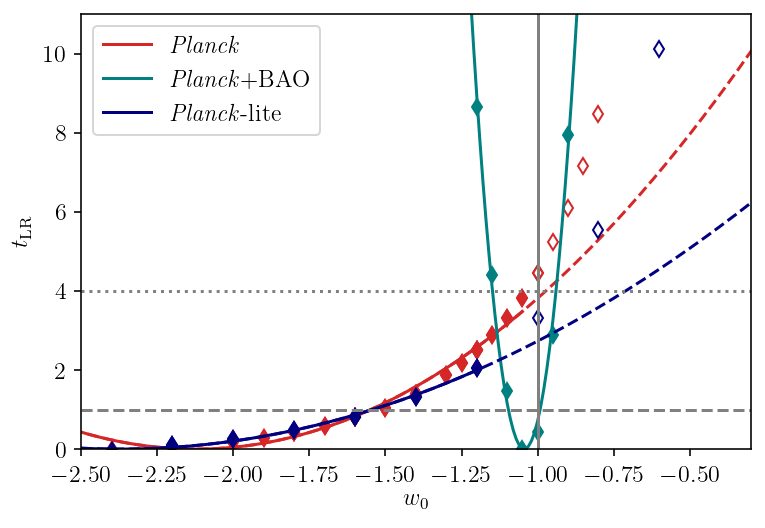

In [11]:
########### Planck
print("Planck")

# Fit parabola
[a,b,c], pcov = curve_fit(parab, w0s_Planck[4:-3], chi2_w0_Planck[4:-3], p0=[2770, 20., -1.3], maxfev=20000)
fit_x = np.arange(-10.0,0.,0.01)
fit_y = b * (fit_x-c)**2.
parabola_min = a

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
zeros = fsolve(parabola, x0=[-10.,0.1])
sigma = (zeros[1]-zeros[0])/2.
print("w0 = ", c, " \pm ", sigma)
print("----------------")

# Plot
plt.plot(w0s_Planck, chi2_w0_Planck-parabola_min, marker="d", ls="", color=color_Planck, fillstyle='none')
plt.plot(w0s_Planck[4:-3], chi2_w0_Planck[4:-3]-parabola_min, marker="d", ls="", color=color_Planck)
label=r"\textit{Planck}"
fit_x_max = 896
plt.plot(fit_x[0:fit_x_max], fit_y[0:fit_x_max], color=color_Planck, ls='-', label=label)
plt.plot(fit_x, fit_y, color=color_Planck , ls='--')

########### Planck+BAO
print("Planck+BAO")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, w0s_BAO, chi2_w0_BAO, p0=[2770, 22., -1.3], maxfev=20000)
fit_x_BAO = np.arange(-4.0,0.,0.01)
fit_y_BAO = b * (fit_x_BAO-c)**2.
parabola_min = a

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
zeros = fsolve(parabola, x0=[-4.,0.1])
sigma = (zeros[1]-zeros[0])/2.
print("w0 = ", c, " \pm ", sigma)
print("----------------")

# Plot
plt.plot(w0s_BAO, chi2_w0_BAO-parabola_min, marker="d", ls="", color=color_BAO)
label=r"\textit{Planck}+BAO"
plt.plot(fit_x_BAO, fit_y_BAO, color=color_BAO, ls='-', label=label)

########### Planck-lite
print("Planck-lite")

#Fit parabola
[a,b,c], pcov = curve_fit(parab, w0s_lite[4:], chi2_w0_lite[4:], p0=[578, 9, -1.8], maxfev=50000)
fit_x = np.arange(-40,0.,0.01)
fit_y = b * (fit_x-c)**2.
parabola_min = a

# Find intersection of parabola with \Delta\chi^2 = 1
def parabola(x):
    return b * (x-c)**2. -1
zeros = fsolve(parabola, x0=[-40.,0.1])
sigma = (zeros[1]-zeros[0])/2.
print("w0 = ", c, " \pm ", sigma)

# Plot
plt.plot(w0s_lite, chi2_w0_lite-parabola_min, marker="d", ls="", color=color_lite , fillstyle='none')
plt.plot(w0s_lite[4:], chi2_w0_lite[4:]-parabola_min, marker="d", ls="", color=color_lite )
label=r"\textit{Planck}-lite"
fit_x_max = 3880
plt.plot(fit_x[0:fit_x_max], fit_y[0:fit_x_max], color=color_lite , ls='-', label=label)
plt.plot(fit_x, fit_y, color=color_lite , ls='--')

########### Make plot
plt.xlabel(r"$w_0$", fontdict=font)
plt.ylabel(r"$t_\mathrm{LR}$", fontdict=font)
plt.ylim(0,11)
plt.xlim(-2.5, -0.3)
plt.axhline(1., color='grey', ls='--')
plt.axhline(4., color='grey', ls=':')
plt.axvline(-1., color='grey', ls='-')
plt.legend()
plt.savefig("PL_w0.pdf", format="PDF")